# Step 1B: Singlet Analysis
Input: `data/processed/human_breast_cancer_singlets_pre_qc.h5ad`

In [1]:
from pathlib import Path
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ROOT = Path.cwd()
if not (ROOT / 'data').exists() and (ROOT.parent / 'data').exists():
    ROOT = ROOT.parent

IN_H5AD = ROOT / 'data/processed/human_breast_cancer_singlets_pre_qc.h5ad'
OUT_H5AD = ROOT / 'data/processed/human_breast_cancer_single_cell.h5ad'
FIG_DIR = ROOT / 'figures/single_cell'
RES_DIR = ROOT / 'results/single_cell'

FIG_DIR.mkdir(parents=True, exist_ok=True)
RES_DIR.mkdir(parents=True, exist_ok=True)

adata = sc.read_h5ad(IN_H5AD)
print('Loaded singlets:', adata.shape)

Loaded singlets: (4214, 2000)


In [2]:
# QC metrics
adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

print(adata.obs[['total_counts', 'n_genes_by_counts', 'pct_counts_mt']].describe())

       total_counts  n_genes_by_counts  pct_counts_mt
count   4214.000000        4214.000000    4214.000000
mean    1959.178711         466.525392       4.131732
std     1229.006714         158.100959       3.030257
min       29.000000          25.000000       0.000000
25%     1092.000000         363.000000       2.089468
50%     1795.500000         489.000000       3.214441
75%     2558.000000         578.000000       5.117522
max    11555.000000         960.000000      21.407625


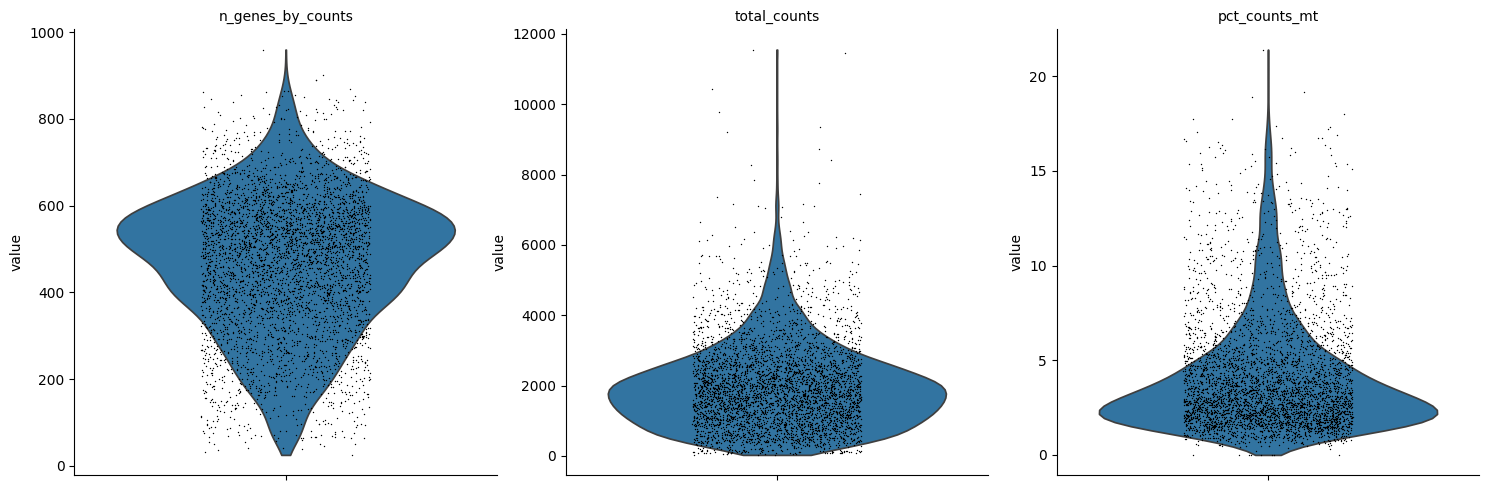

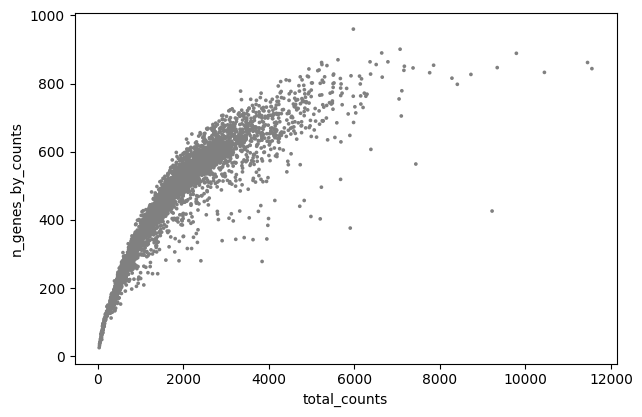

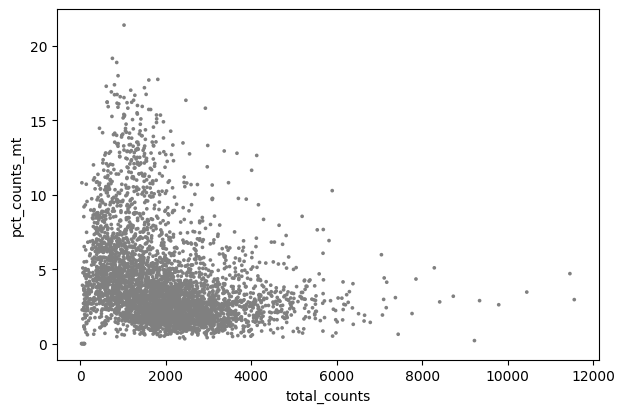

In [3]:
# QC plots (show + save)
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.2,
    multi_panel=True,
    show=True
)
plt.show()
plt.savefig(FIG_DIR / 'step1b_qc_violin.png', dpi=300, bbox_inches='tight')
plt.close()

sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', show=True)
plt.show()
plt.savefig(FIG_DIR / 'step1b_qc_scatter_counts_genes.png', dpi=300, bbox_inches='tight')
plt.close()

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', show=True)
plt.show()
plt.savefig(FIG_DIR / 'step1b_qc_scatter_counts_mt.png', dpi=300, bbox_inches='tight')
plt.close()

In [4]:
# QC filtering
n_before = adata.n_obs

adata = adata[adata.obs['n_genes_by_counts'] >= 200].copy()
adata = adata[adata.obs['pct_counts_mt'] < 20].copy()

upper_gene = np.quantile(adata.obs['n_genes_by_counts'], 0.99)
adata = adata[adata.obs['n_genes_by_counts'] < upper_gene].copy()

sc.pp.filter_genes(adata, min_cells=3)

print('Before QC:', n_before, 'After QC:', adata.n_obs, 'Genes:', adata.n_vars)

Before QC: 4214 After QC: 3897 Genes: 2000


In [5]:
# Normalize + log
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
print('Normalized/logged:', adata.shape)

Normalized/logged: (3897, 2000)


HVG: 2000


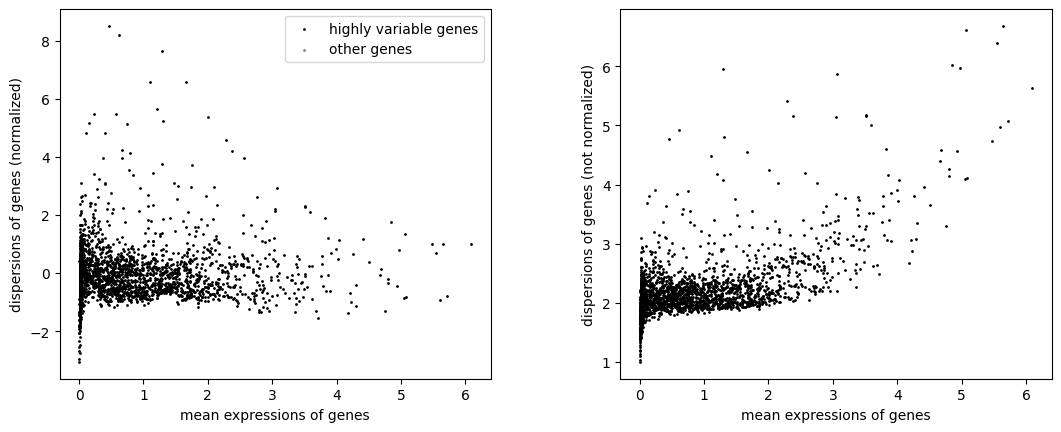

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.3312.0_x64__qbz5n2kfra8p0\Lib\functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


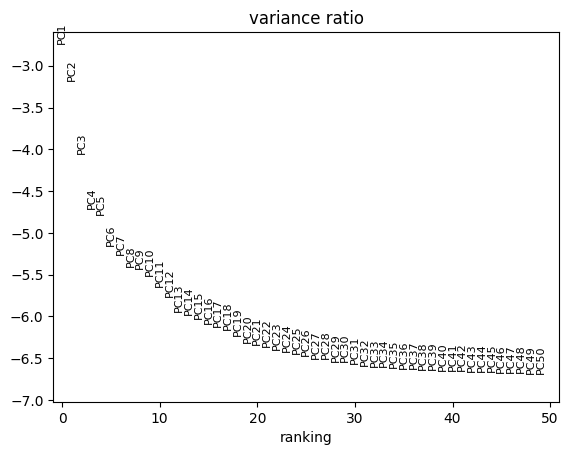

In [6]:
# HVG + scale + PCA
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat')
print('HVG:', int(adata.var['highly_variable'].sum()))

sc.pl.highly_variable_genes(adata, show=True)
plt.show()
plt.savefig(FIG_DIR / 'step1b_hvg.png', dpi=300, bbox_inches='tight')
plt.close()

adata = adata[:, adata.var['highly_variable']].copy()
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50, show=True)
plt.show()
plt.savefig(FIG_DIR / 'step1b_pca_variance_ratio.png', dpi=300, bbox_inches='tight')
plt.close()

C:\Users\mmsid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\mmsid\AppData\Local\Temp\ipykernel_15712\4202490545.py:4: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata, resolution=0.8)


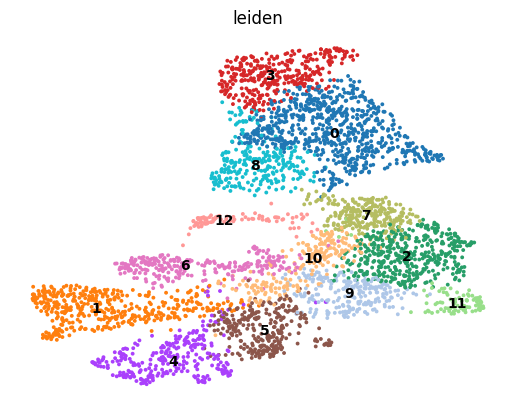

,cluster,count
0,0,715
1,1,440
2,2,426
3,3,336
4,4,293
5,5,283
6,6,276
7,7,264
8,8,253
9,9,226


In [7]:
# Neighbors + UMAP + Leiden
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.8)

sc.pl.umap(adata, color='leiden', legend_loc='on data', frameon=False, show=True)
plt.show()
plt.savefig(FIG_DIR / 'step1b_umap_leiden.png', dpi=300, bbox_inches='tight')
plt.close()

cluster_counts = adata.obs['leiden'].value_counts().sort_index()
cluster_df = pd.DataFrame({'cluster': cluster_counts.index, 'count': cluster_counts.values})
cluster_df.to_csv(RES_DIR / 'Human Breast Cancer_clusters_step1b.csv', index=False)
display(cluster_df.head(20))

In [8]:
# Marker genes (full + top20)
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')
markers = sc.get.rank_genes_groups_df(adata, group=None)
markers.to_csv(RES_DIR / 'Human Breast Cancer_marker_genes_all_step1b.csv', index=False)

top20 = markers.groupby('group', as_index=False).head(20)
top20.to_csv(RES_DIR / 'Human Breast Cancer_marker_genes_top20_step1b.csv', index=False)
display(top20.head(20))

C:\Users\mmsid\AppData\Local\Temp\ipykernel_15712\4136270800.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top20 = markers.groupby('group', as_index=False).head(20)


,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,TCEAL4,38.074978,2.773804,0.000000e+00,0.000000e+00
1,0,CXCL14,36.599068,4.145746,2.959303e-293,2.959303e-290
2,0,GNG5,35.978676,2.493208,1.803051e-283,1.202034e-280
3,0,CCND1,35.590580,2.207644,1.959492e-277,9.797458e-275
4,0,MORF4L2,35.174122,2.429443,4.973720e-271,1.989488e-268
5,0,KRT18,33.786938,1.386102,3.067779e-250,1.022593e-247
6,0,MUC1,33.611366,1.941919,1.144611e-247,3.270316e-245
7,0,KRT8,33.445999,1.541041,2.942622e-245,7.356554e-243
8,0,TTLL12,33.086208,3.273967,4.692682e-240,1.042818e-237
9,0,TUBA1B,32.336060,1.392964,2.178625e-229,4.357250e-227


In [9]:
# Save processed object
adata.write_h5ad(OUT_H5AD)
print('Saved:', OUT_H5AD)

Saved: c:\Users\mmsid\Documents\github\My Project\spatial_biology_project\data\processed\human_breast_cancer_single_cell.h5ad
